# Copy instead of modifying to preserve attack parameters

In [1]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_500'
DATASET_NAME = 'citylearn_challenge_2022_phase_2' #only action is electrical storage
RUNS = 5
TRIAL = 2

In [2]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from art.attacks.evasion import AutoConjugateGradient as ACG

import pandas as pd
import numpy as np

import KBMproject.utilities as utils

from joblib import Parallel, delayed

%matplotlib inline

In [3]:
schema = DataSet.get_schema(DATASET_NAME)

Define RL agent

In [4]:
agents = []
for _ in range (RUNS):
    agents.append(PPO.load(path=f"{AGENT_NAME}"))

In [5]:
envs = []
for _ in range (RUNS):
    envs.append(utils.make_discrete_env(schema=schema,  
                            action_bins=agents[0].action_space[0].n,
                            seed=42))

Unperturbed agent performance

In [6]:
import os
path = os.path.join(os.getcwd(), '..','observation_masks.csv') #get adversary from parent directory
path = os.path.normpath(path) #resolve '..'
observation_masks = pd.read_csv(path)

In [9]:
%%time
results = Parallel(n_jobs=RUNS, verbose=10, prefer='threads')(delayed(
    utils.eval_agent)(env, agent) for agent, env in zip(agents, envs)) 


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.9min remaining:  4.3min
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:  2.9min remaining:  2.0min


CPU times: total: 3min 40s
Wall time: 2min 56s


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Results is a list of tupples for each run, of the format(KPIs, observations, perturbed observations, asr)

In [12]:
kpis = [results[i][0] for i in range(len(results))]
df_kpis = pd.concat(kpis, axis='columns',keys=range(RUNS))

In [13]:
df_kpis[['mean', 'std', 'variance']] = df_kpis.agg(['mean','std', 'var'], axis='columns')

In [14]:
df_kpis

,0,1,2,3,4,mean,std,variance
cost_function,,,,,,,,
annual_peak_average,1.102271,1.102271,1.102271,1.102271,1.102271,1.102271,0.000000e+00,0.000000e+00
carbon_emissions_total,0.869186,0.869186,0.869186,0.869186,0.869186,0.869186,1.241267e-16,1.540744e-32
cost_total,0.787803,0.787803,0.787803,0.787803,0.787803,0.787803,0.000000e+00,0.000000e+00
daily_one_minus_load_factor_average,1.095762,1.095762,1.095762,1.095762,1.095762,1.095762,0.000000e+00,0.000000e+00
daily_peak_average,0.894595,0.894595,0.894595,0.894595,0.894595,0.894595,1.241267e-16,1.540744e-32
electricity_consumption_total,0.879108,0.879108,0.879108,0.879108,0.879108,0.879108,1.241267e-16,1.540744e-32
monthly_one_minus_load_factor_average,0.988364,0.988364,0.988364,0.988364,0.988364,0.988364,0.000000e+00,0.000000e+00
ramping_average,1.093749,1.093749,1.093749,1.093749,1.093749,1.093749,0.000000e+00,0.000000e+00
zero_net_energy,1.107710,1.107710,1.107710,1.107710,1.107710,1.107710,0.000000e+00,0.000000e+00


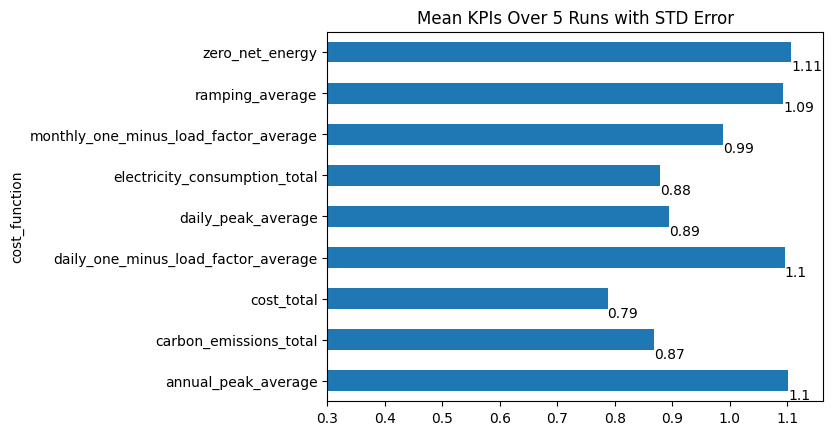

In [15]:
ax = df_kpis['mean'].plot.barh(xerr = df_kpis['std'], xlim=0.3, title='Mean KPIs Over 5 Runs with STD Error')
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width(), 
            i.get_y()-0.2,
            str(round((i.get_width()), 2)), 
            fontsize=10, 
            #color='dimgrey'
            )